In [1]:
%pip install coremltools
%pip install timm
%pip install opencv-python
%pip install thop
%pip install pandas
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch

config = {
    'classical_sr' : {
        'args': {
            'upscale' : 2, # flexible
            'in_chans' : 3,
            'img_size' : 48,
            'window_size' : 8,
            'img_range' : 1.,
            'depths' :[6, 6, 6, 6, 6, 6],
            'embed_dim' : 180,
            'num_heads' : [6, 6, 6, 6, 6, 6],
            'mlp_ratio' : 2,
            'upsampler' : 'pixelshuffle',
            'resi_connection' : '1conv',
        },
        'path' : 'model_zoo/swinir/001_classicalSR_DIV2K_s48w8_SwinIR-M_x2.pth', #match with upscale factor
    },
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',

    'lightweight_sr' : {
        'args': {
            'upscale' : 2, # flexible
            'in_chans' : 3,
            'img_size' : 64,
            'window_size' : 8,
            'img_range' : 1.,
            'depths' :[6, 6, 6, 6],
            'embed_dim' : 60,
            'num_heads' : [6, 6, 6, 6],
            'mlp_ratio' : 2,
            'upsampler' : 'pixelshuffledirect',
            'resi_connection' : '1conv',
        },
        'path' : 'model_zoo/swinir/002_lightweightSR_DIV2K_s64w8_SwinIR-S_x2.pth', #match with upscale factor
    }
}

In [32]:
from models.network_swinir import SwinIR as net

device = config['device']
TASK_NAME = 'lightweight_sr'


model_info = config[TASK_NAME]
model = net(**model_info['args'])
param_key_g = 'params'

pretrained_model = torch.load(model_info['path'])
model.load_state_dict(pretrained_model[param_key_g] if param_key_g in pretrained_model.keys() else pretrained_model, strict=True)
model.to(device)

SwinIR(
  (conv_first): Conv2d(3, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (patch_embed): PatchEmbed(
    (norm): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
  )
  (patch_unembed): PatchUnEmbed()
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): RSTB(
      (residual_group): BasicLayer(
        dim=60, input_resolution=(64, 64), depth=6
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=60, input_resolution=(64, 64), num_heads=6, window_size=8, shift_size=0, mlp_ratio=2
            (norm1): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=60, window_size=(8, 8), num_heads=6
              (qkv): Linear(in_features=60, out_features=180, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=60, out_features=60, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (s

In [104]:
import importlib
from torch.nn.utils.prune import global_unstructured, L1Unstructured
import copy
import pruning_utils as pu
importlib.reload(pu)
mod2prune = copy.deepcopy(model)

parameters_to_prune = [
    (module, name) for module in mod2prune.modules()
    for name, param in module.named_parameters(recurse=False)
]

orig_params = copy.deepcopy(parameters_to_prune)
n_iter = 5
for itr in range(n_iter):
    global_unstructured(
        parameters_to_prune,
        pruning_method=L1Unstructured,
        amount=0.33
    )

print(f'\noverall sparsity: {pu.calculate_sparsity_overall(mod2prune, parameters_to_prune):.4f}')
print(f'model size: {pu.calculate_sparse_model_size(mod2prune, temp_file=f"pruned_models/unstructured_itr_{n_iter}.pt"):.2f} MB')


overall sparsity: 0.8650
model sparsity: 0.8510
model size: 16.41 MB


In [85]:
print(f'model size: {pu.calculate_sparse_model_size(model):.2f} MB')

model sparsity: 0.0000
model size: 34.07 MB


In [ ]:
pruning_data_unstructured = {
    "Iteration" : [0, 1, 2, 3, 4, 5],
    "Sparsity" : [0.0, 0.33, 0.5511, 0.6992, 0.7985, 0.8650],
    "Accuracy" : [],
    "Latency (s)" : [],
    "Disk Size (MB)" : [34.07, 27.23, 22.52, 19.56, 17.65, 16.40],
}

## Structured pruning

### Pruning Attention Heads

pruning: 0 heads


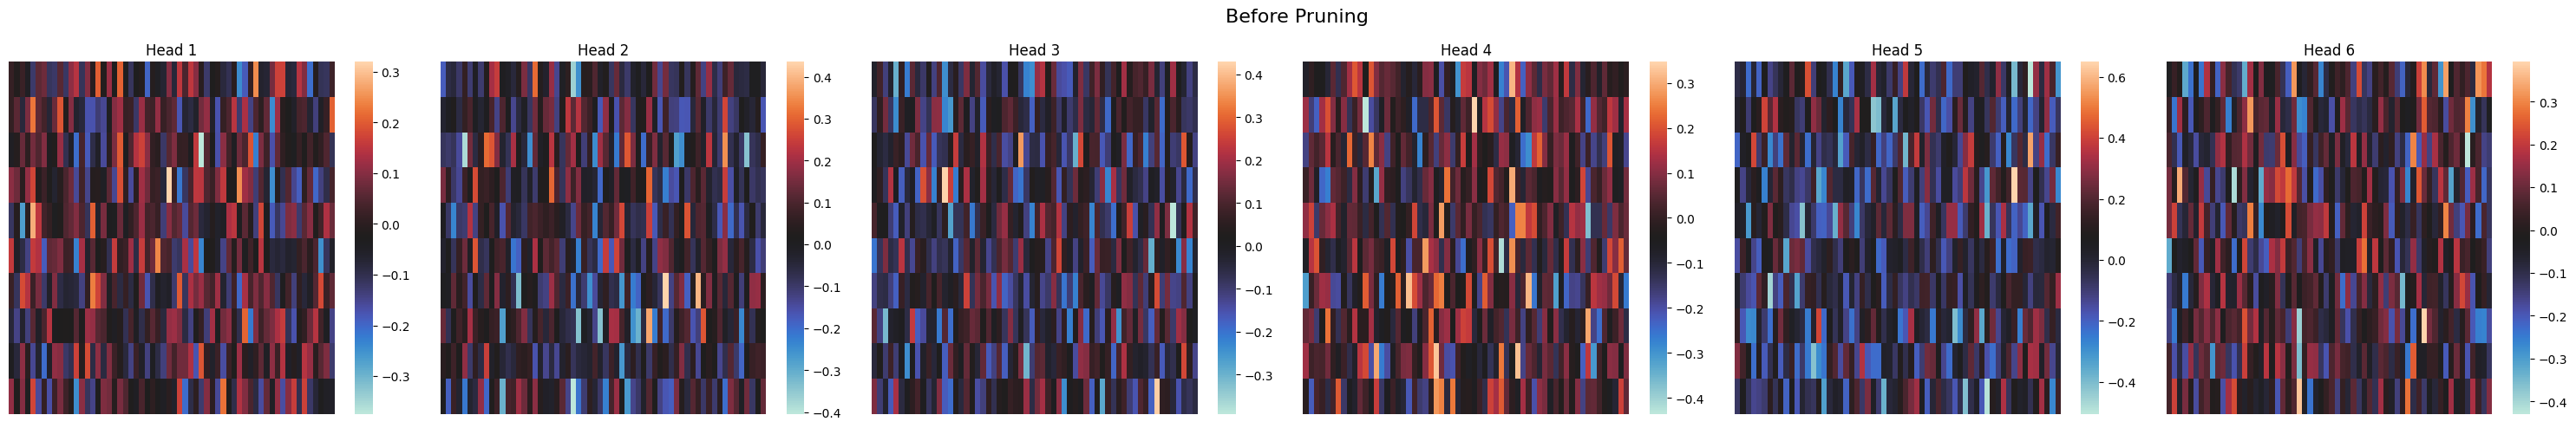

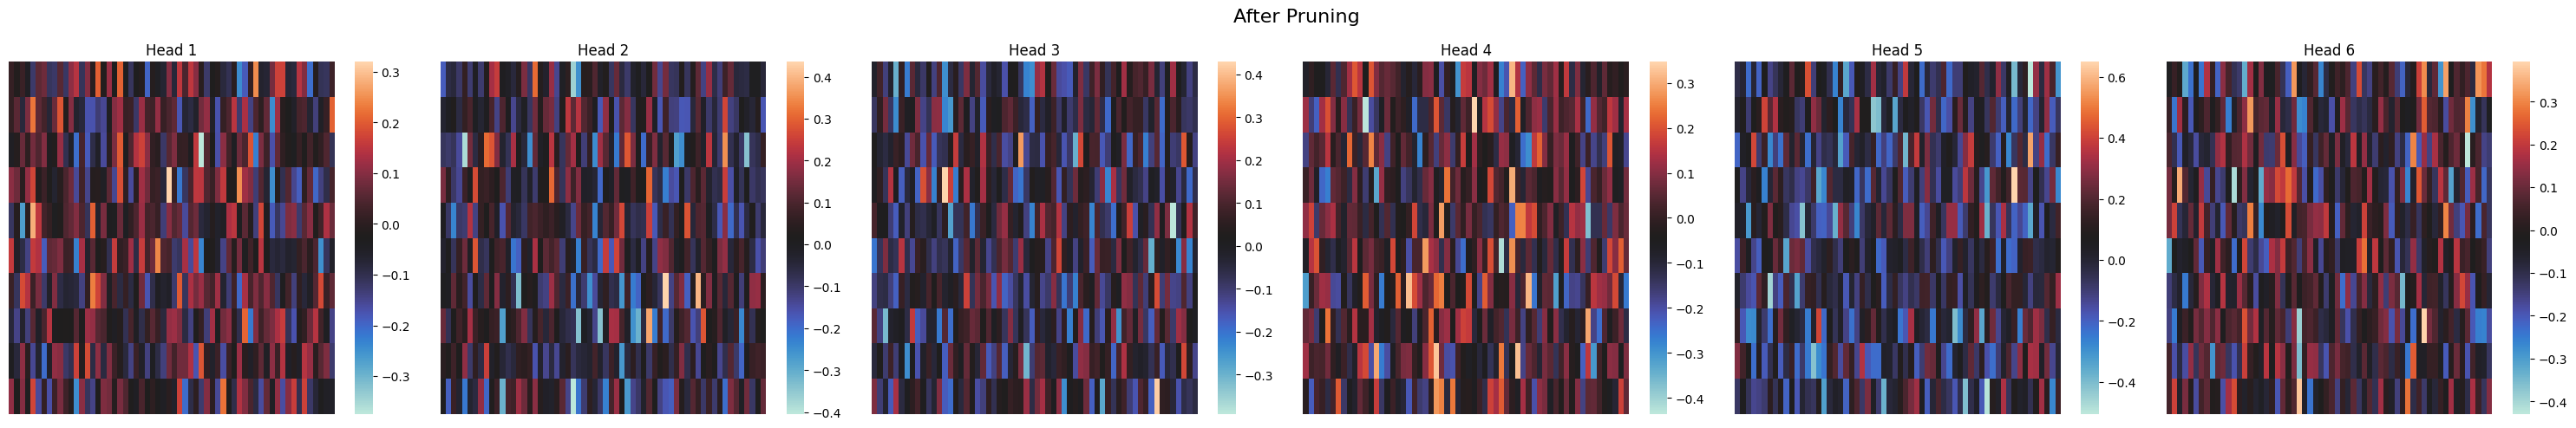

Overall sparsity: 0.0000
model sparsity: 0.0000
sparse model size: 34.0811
------------------------------
pruning: 1 heads


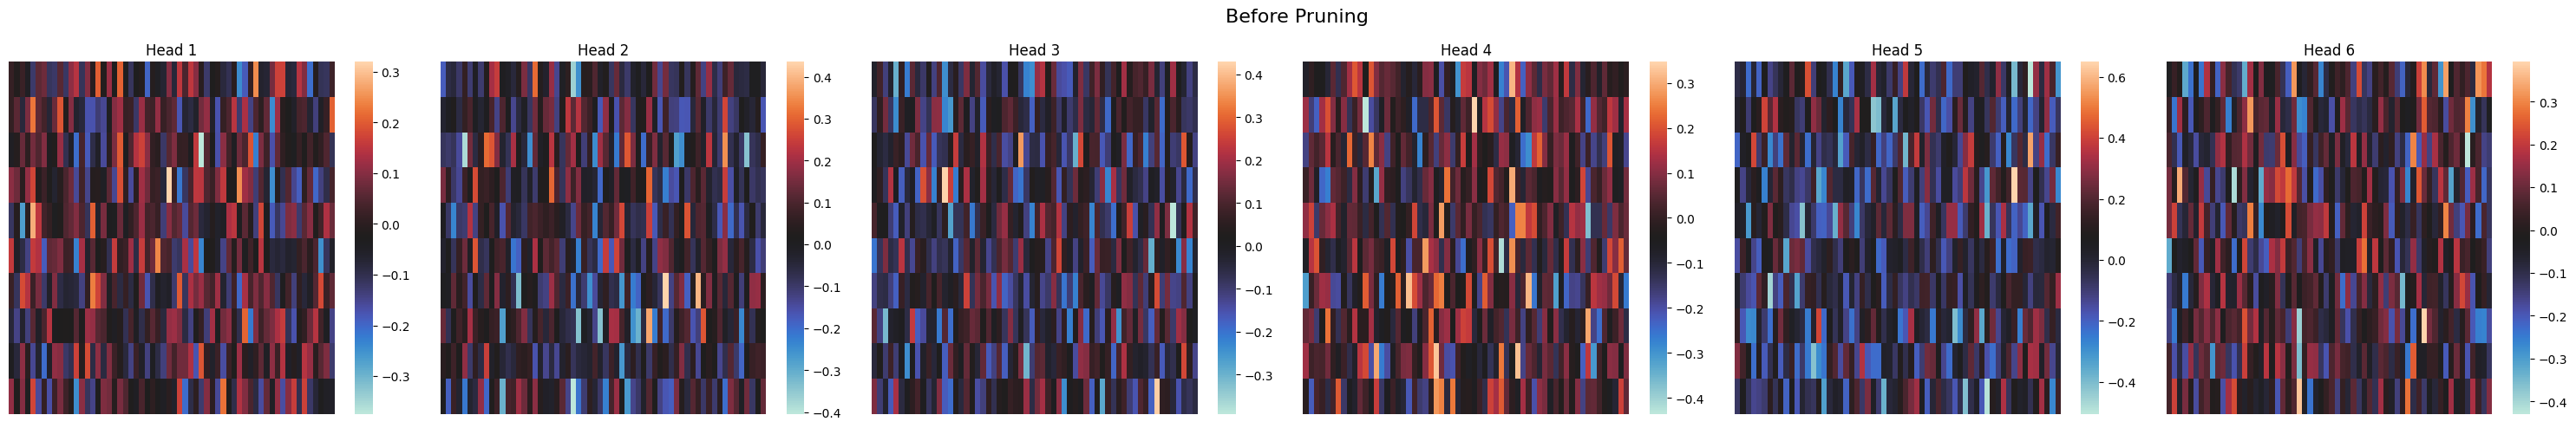

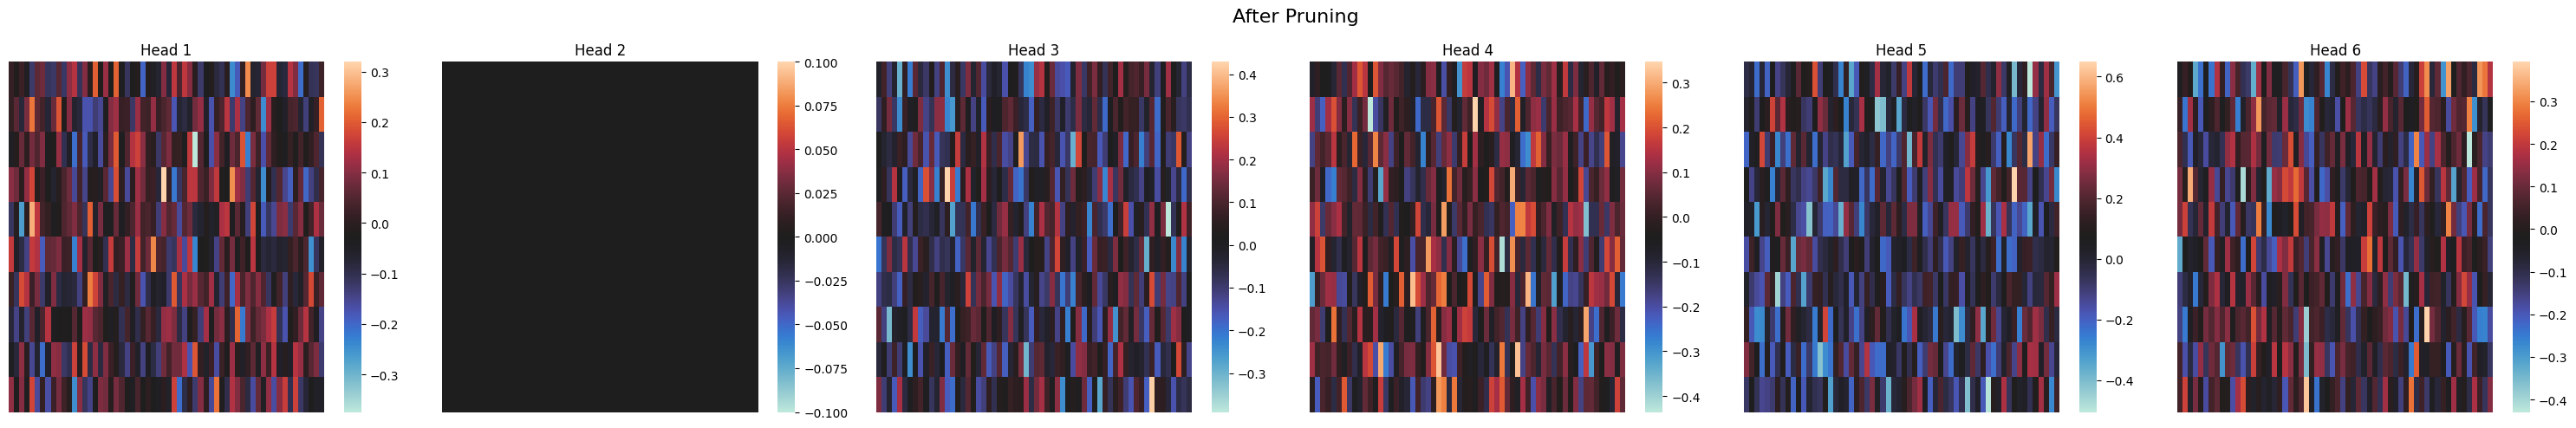

Overall sparsity: 0.1667
model sparsity: 0.0475
sparse model size: 33.2164
------------------------------
pruning: 2 heads


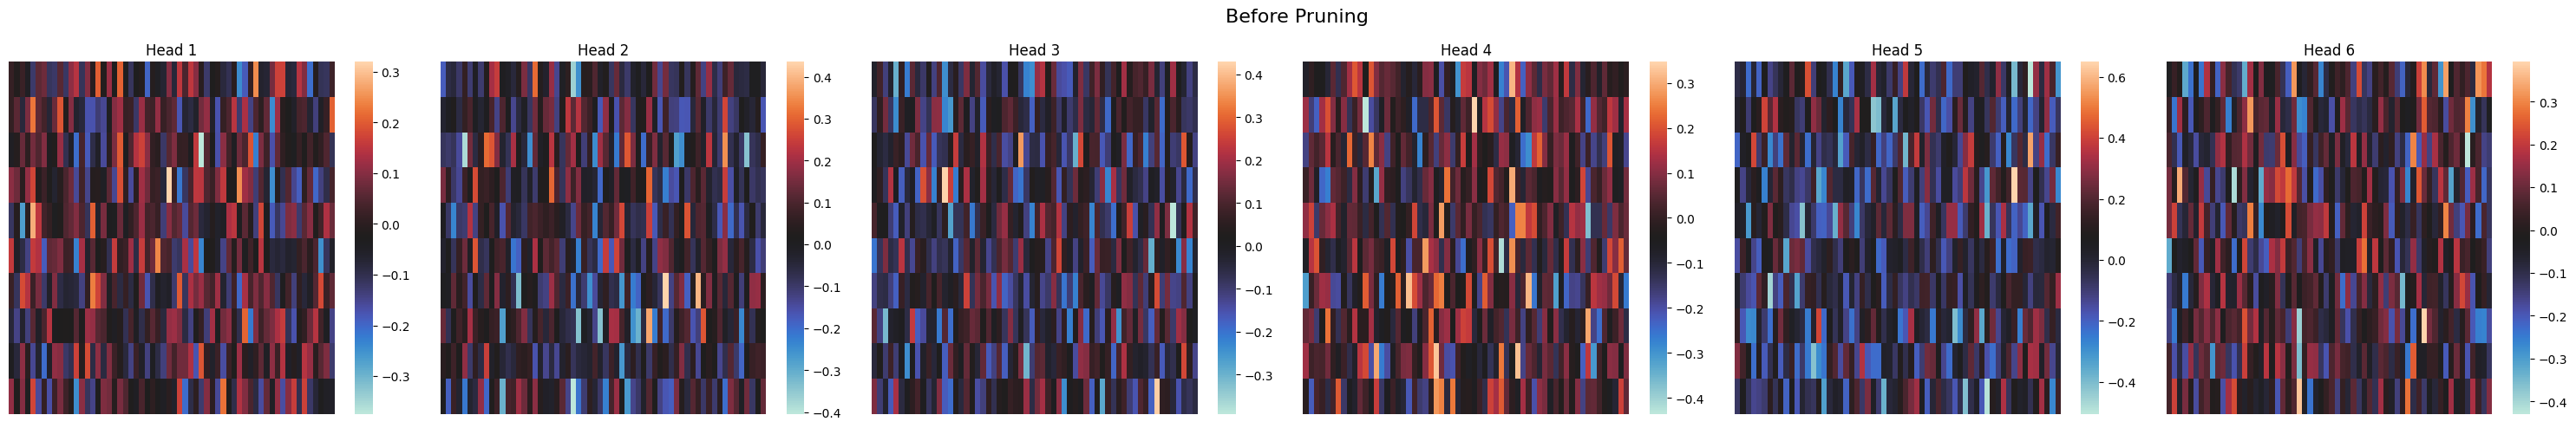

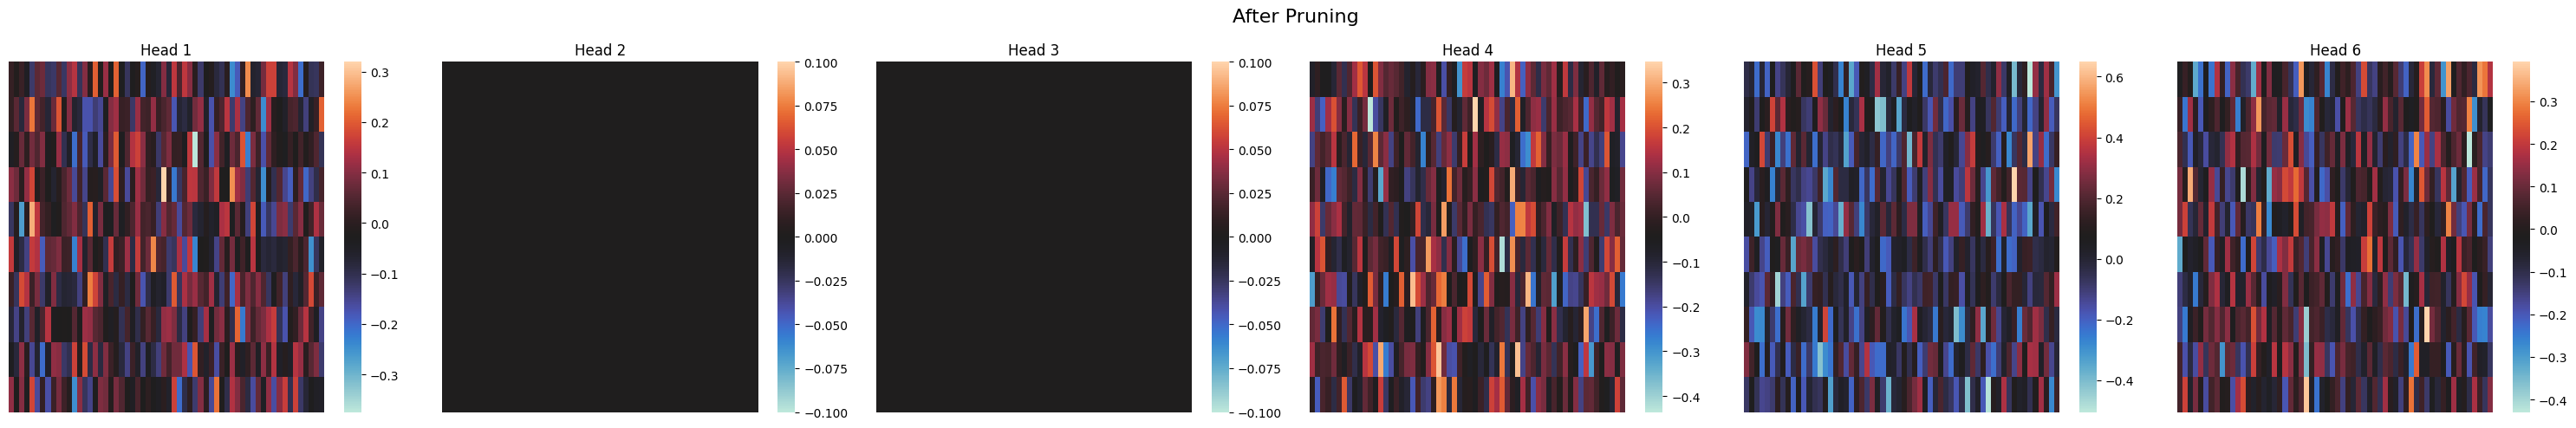

Overall sparsity: 0.3333
model sparsity: 0.0949
sparse model size: 32.3531
------------------------------
pruning: 3 heads


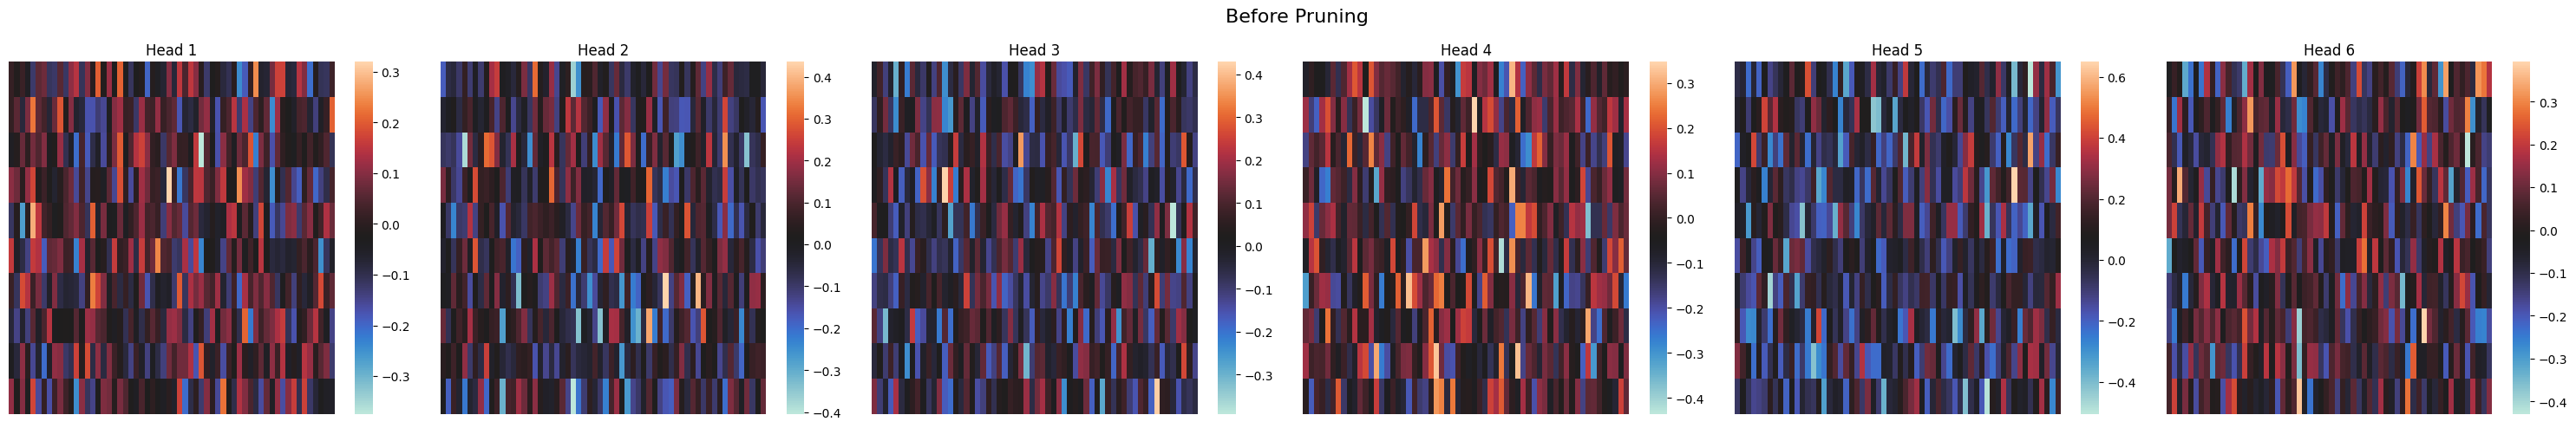

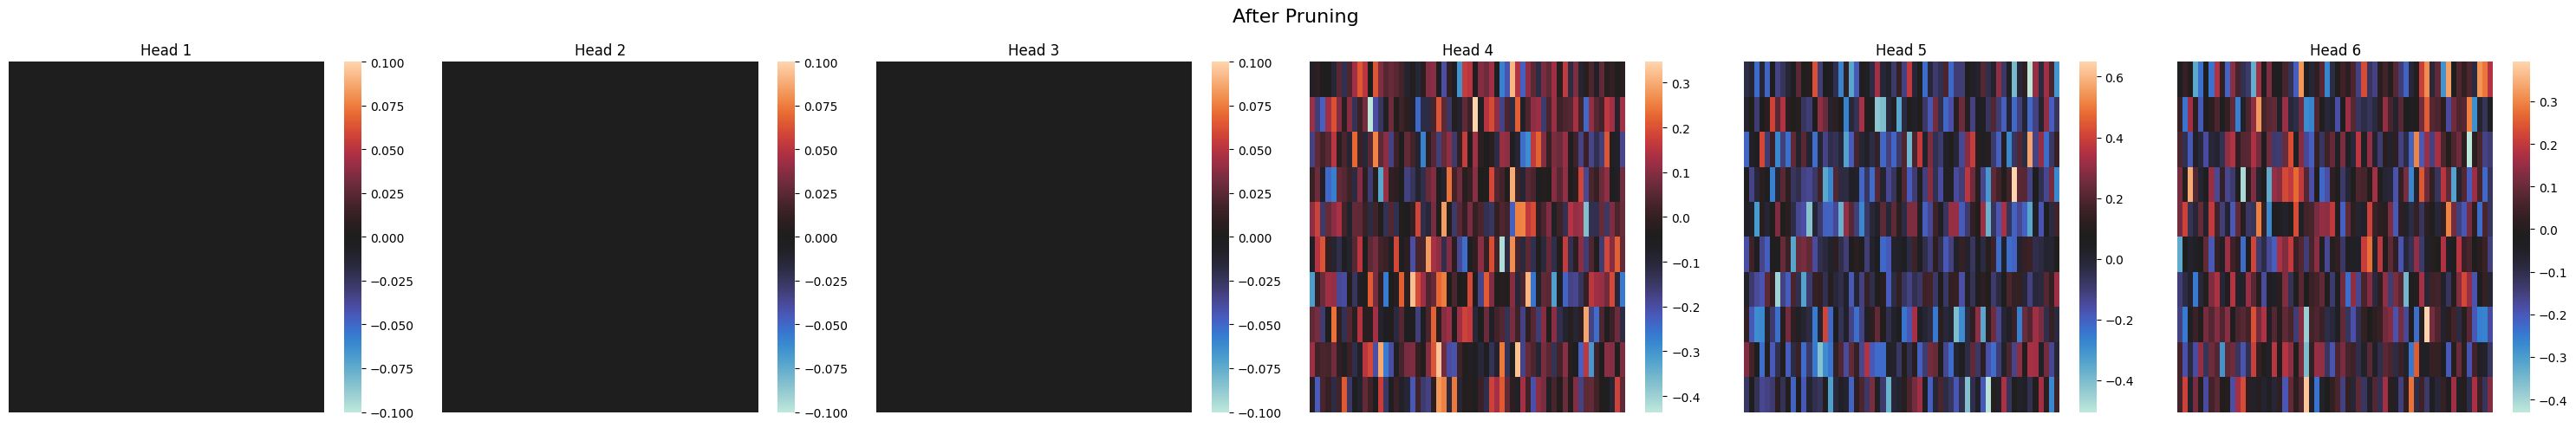

Overall sparsity: 0.5000
model sparsity: 0.1424
sparse model size: 31.4884
------------------------------
pruning: 4 heads


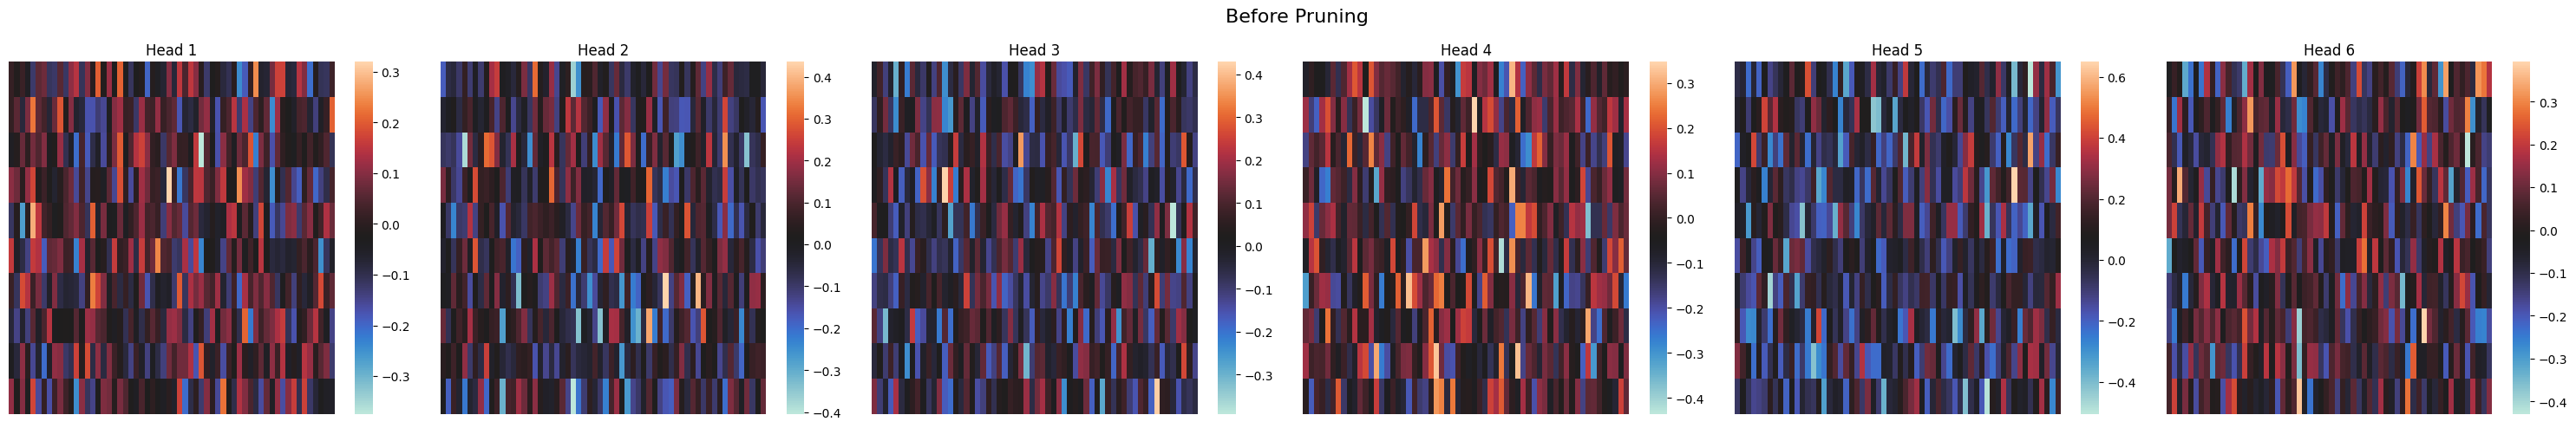

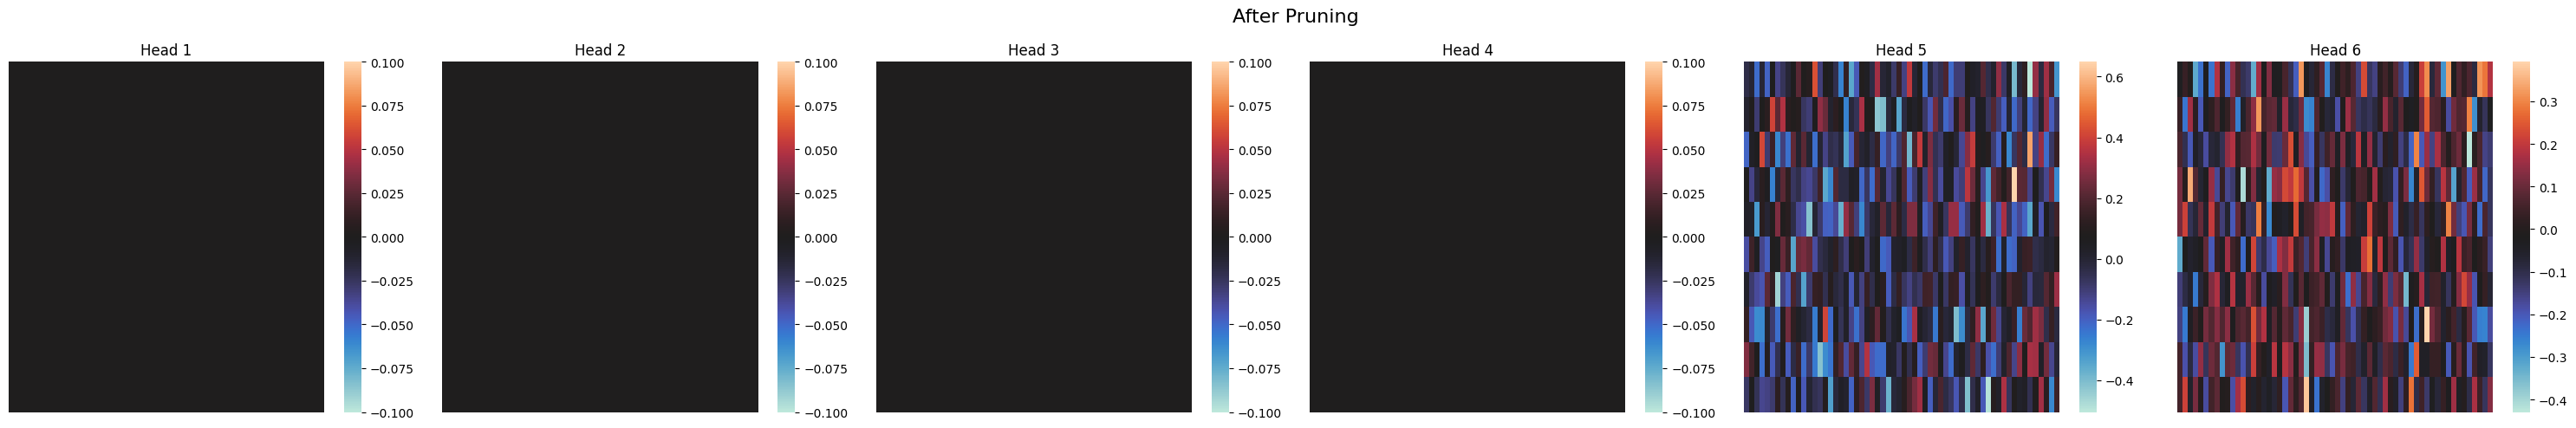

Overall sparsity: 0.6667
model sparsity: 0.1899
sparse model size: 30.6251
------------------------------
pruning: 5 heads


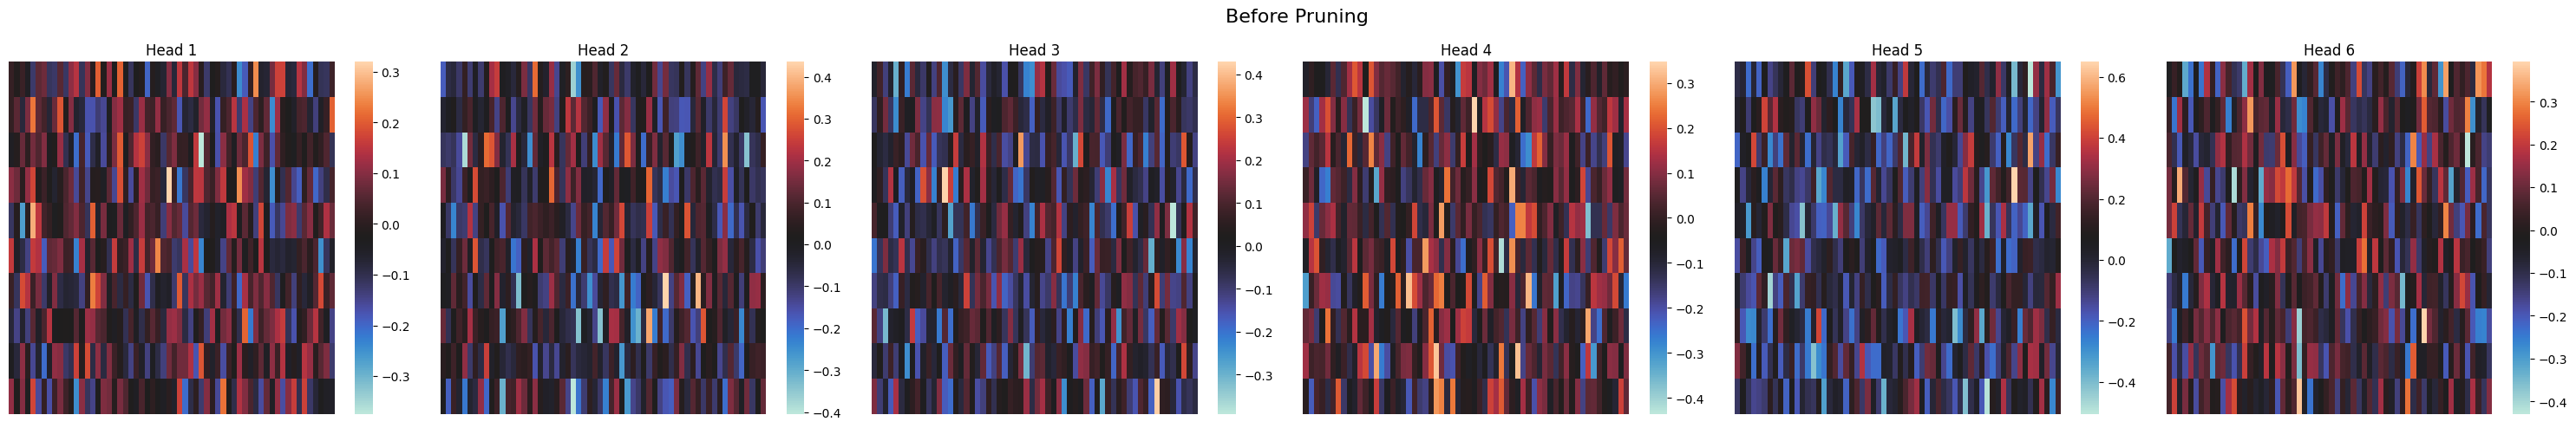

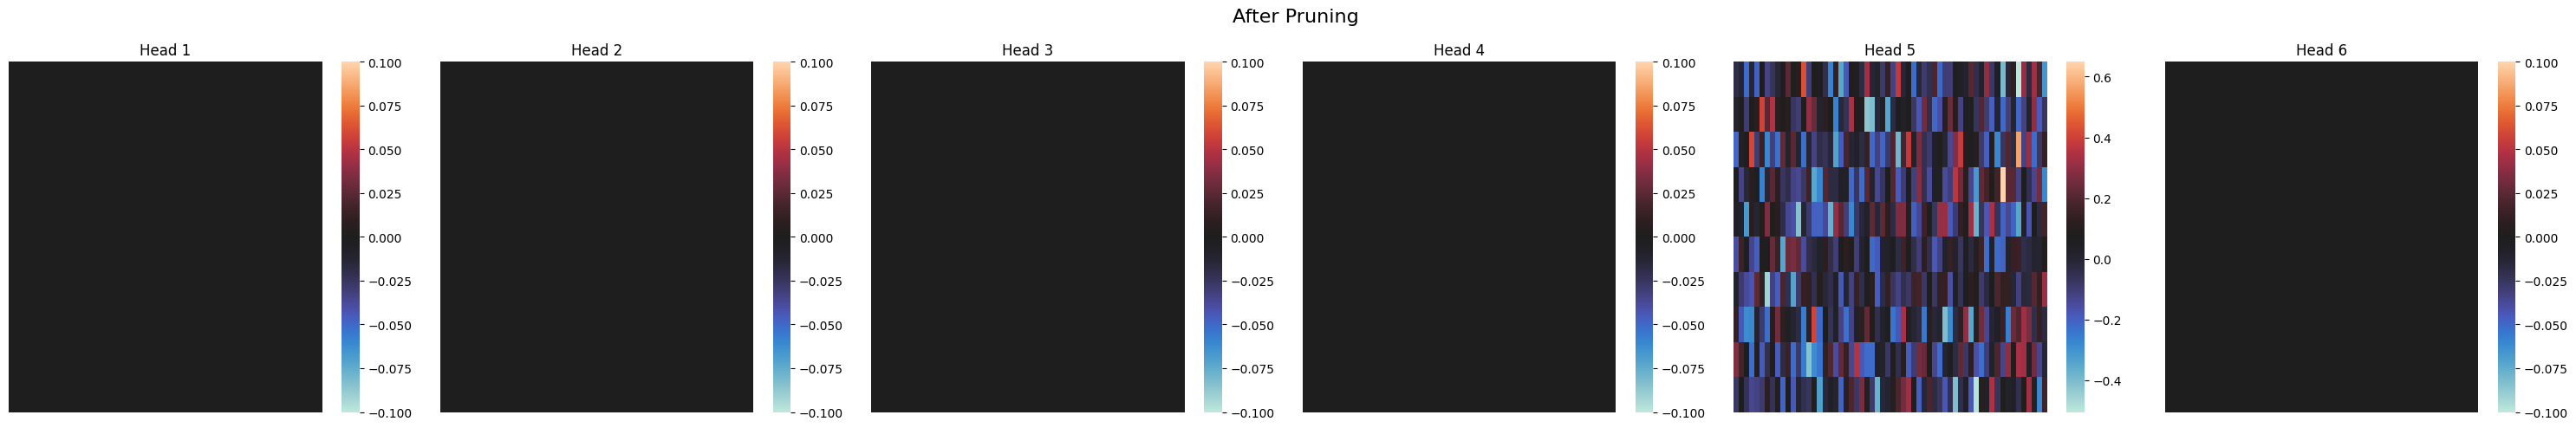

Overall sparsity: 0.8333
model sparsity: 0.2373
sparse model size: 29.7604
------------------------------
pruning: 6 heads


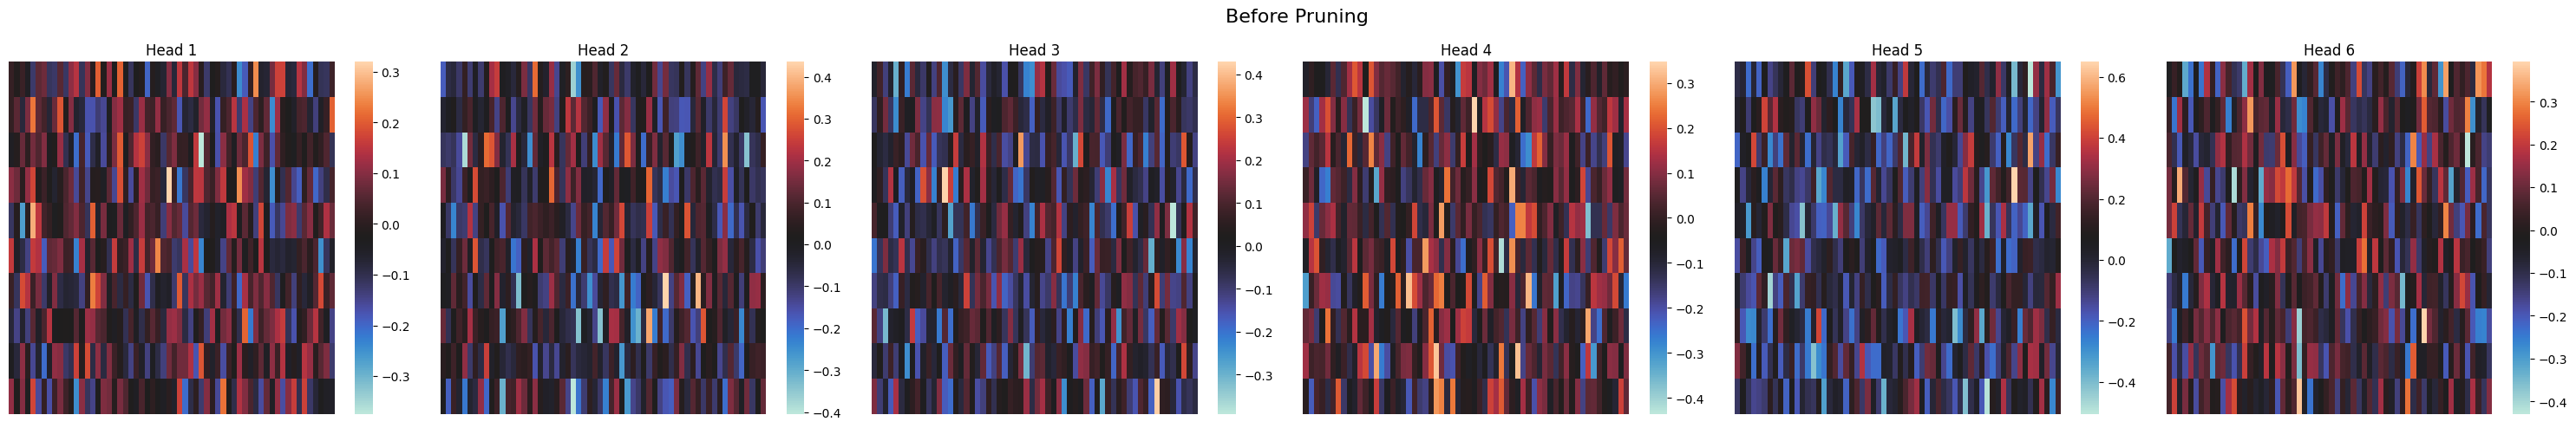

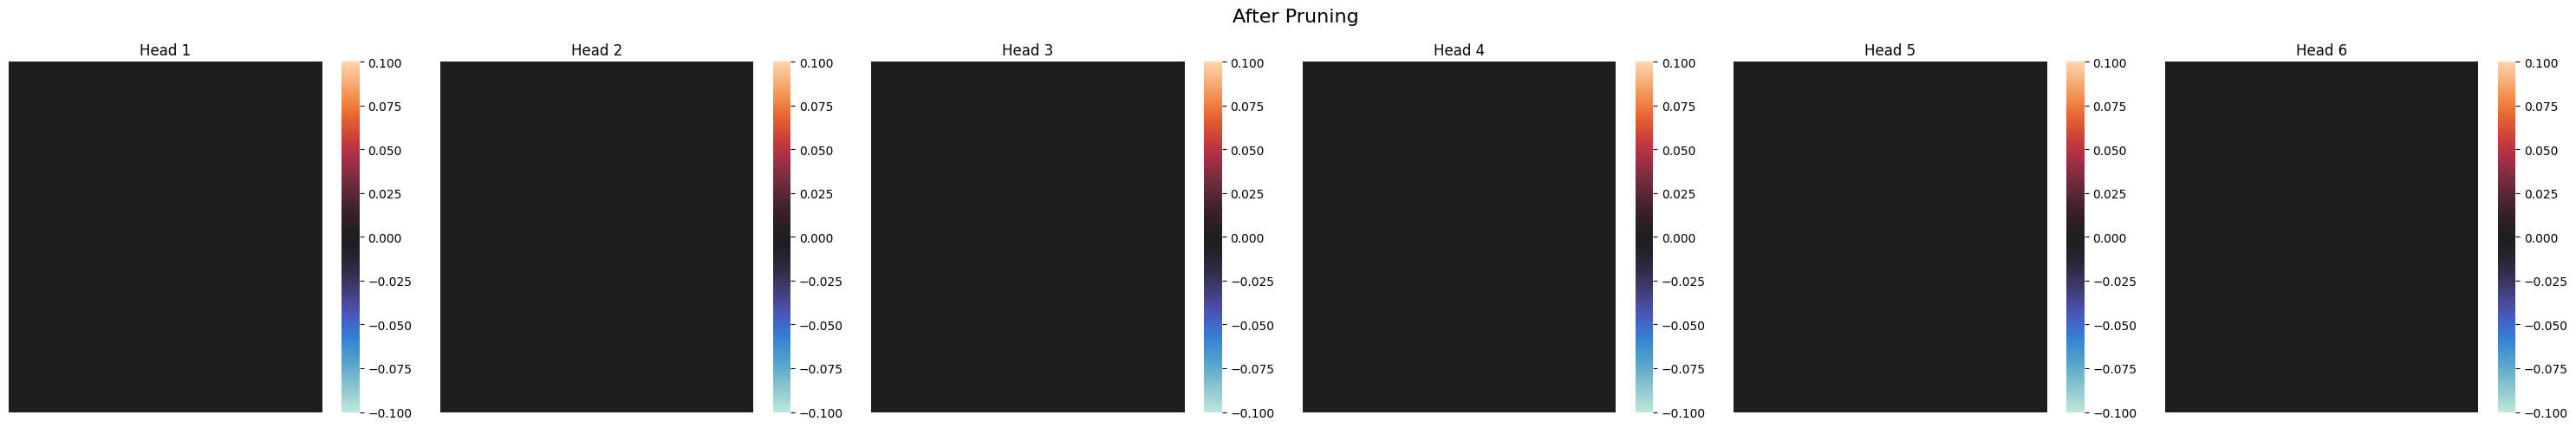

Overall sparsity: 1.0000
model sparsity: 0.2848
sparse model size: 28.8970
------------------------------


In [163]:
importlib.reload(pu) #reloading the module to reflect changes in the file
for ph in range(7): # swinIR has 6 attention heads, so we are pruning 0 (none) to 6 (all) heads
    print(f"pruning: {ph} heads")
    mod2prune = copy.deepcopy(model)
    pu.prune_attn_heads(mod2prune, ph, 20) #pruning ph heads and plotting every 10 layers
    print("-"*30)


In [ ]:
pruning_data_structured_attn_heads = {
    "Heads Pruned" : [0, 1, 2, 3, 4, 5, 6],
    "Sparsity (Heads)" : [0.0, 0.1667, 0.3333, 0.5, 0.6667, 0.8333, 1.0],
    "Sparsity (Model)" : [0.0, 0.0475, 0.0949, 0.1424, 0.1899, 0.2373, 0.2848],
    "Accuracy" : [],
    "Latency (s)" : [],
    "Disk Size (MB)" : [34.07, 33.20, 32.34, 31.47, 30.61, 29.75, 28.88],

}

### Pruning Linear Layer Neurons

pruning: 0 neurons


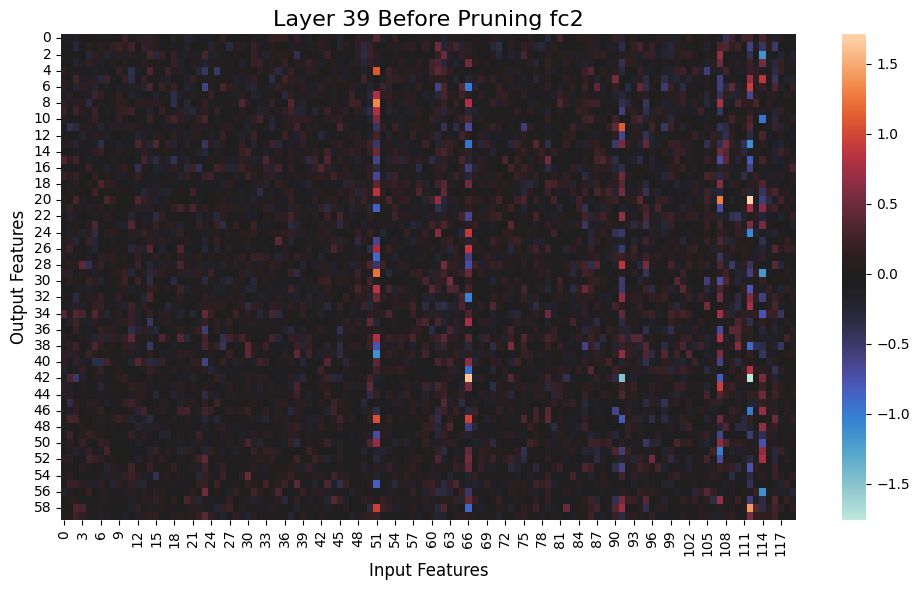

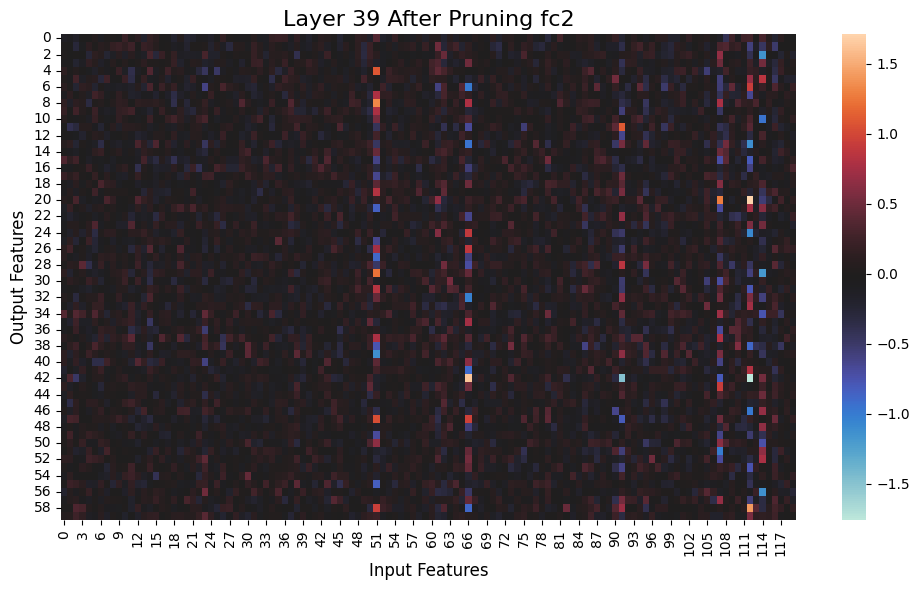

Overall sparsity: 0.0000
model sparsity: 0.0000
sparse model size: 34.0811
------------------------------
pruning: 10 neurons


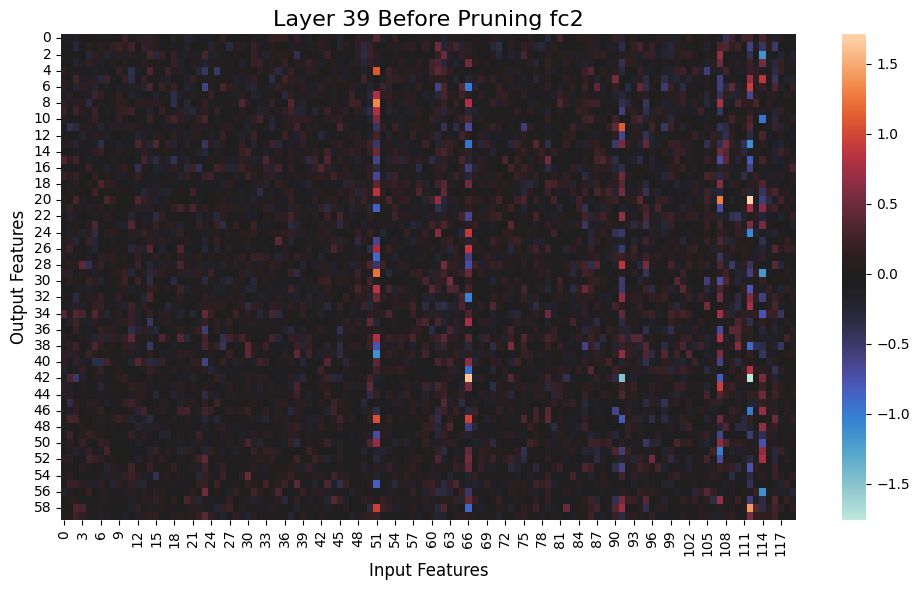

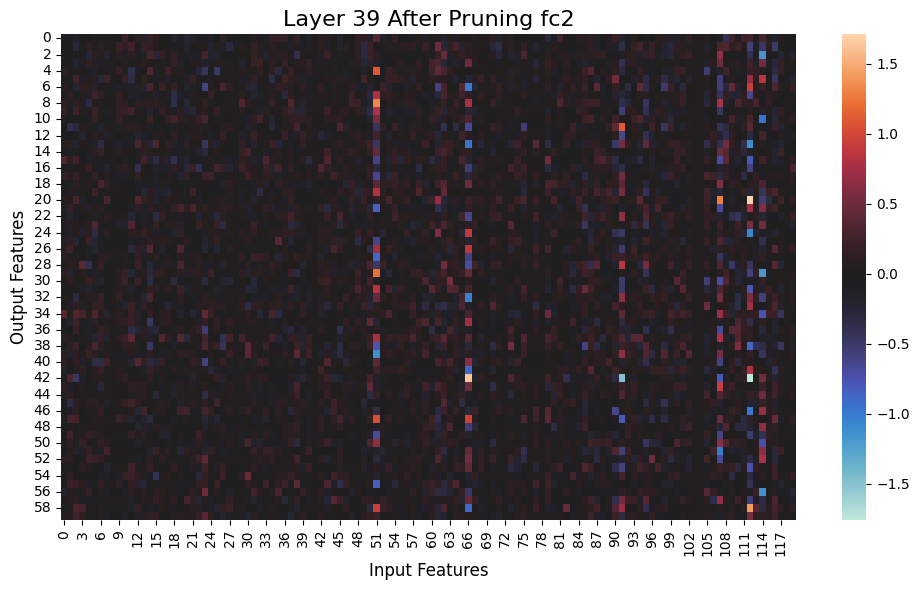

Overall sparsity: 0.1250
model sparsity: 0.0475
sparse model size: 33.2172
------------------------------
pruning: 20 neurons


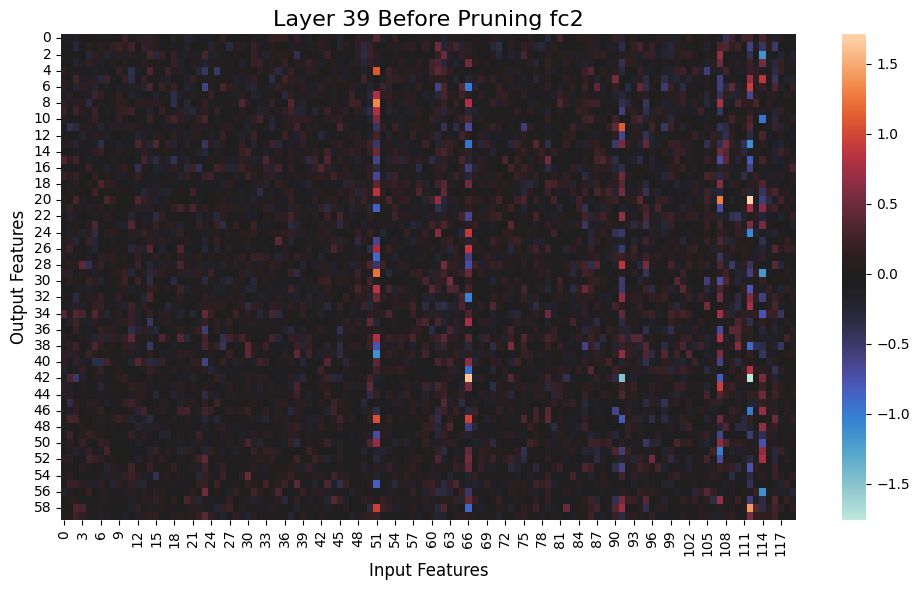

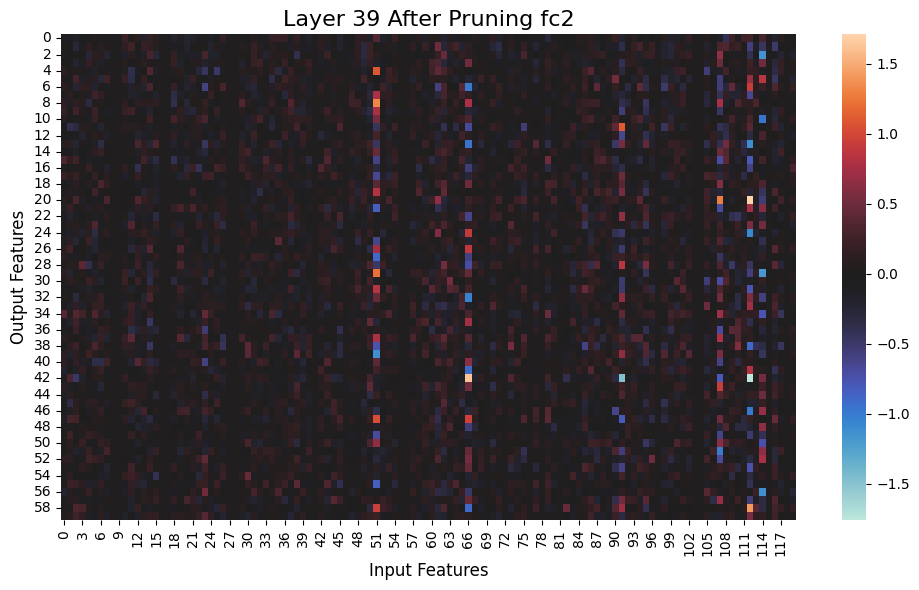

Overall sparsity: 0.2500
model sparsity: 0.0949
sparse model size: 32.3540
------------------------------
pruning: 30 neurons


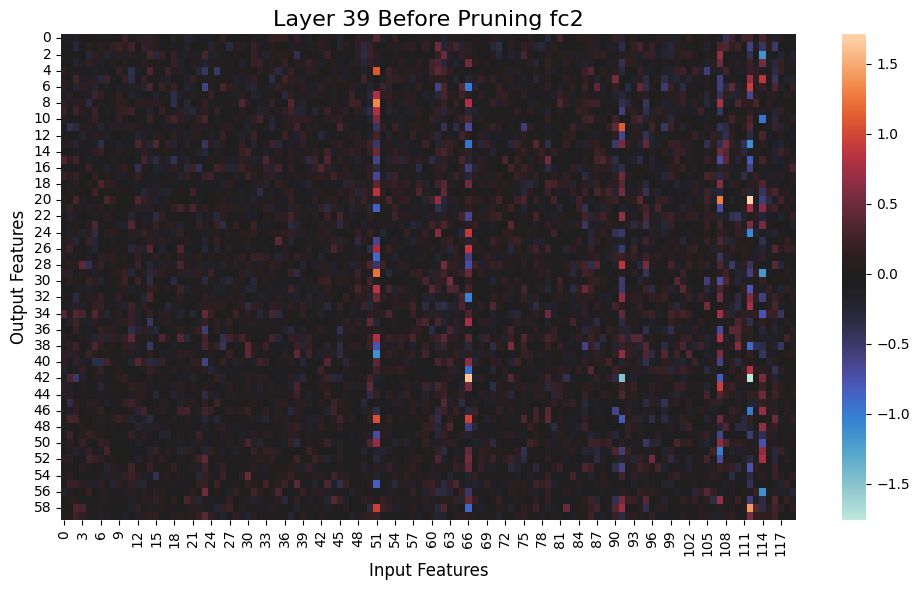

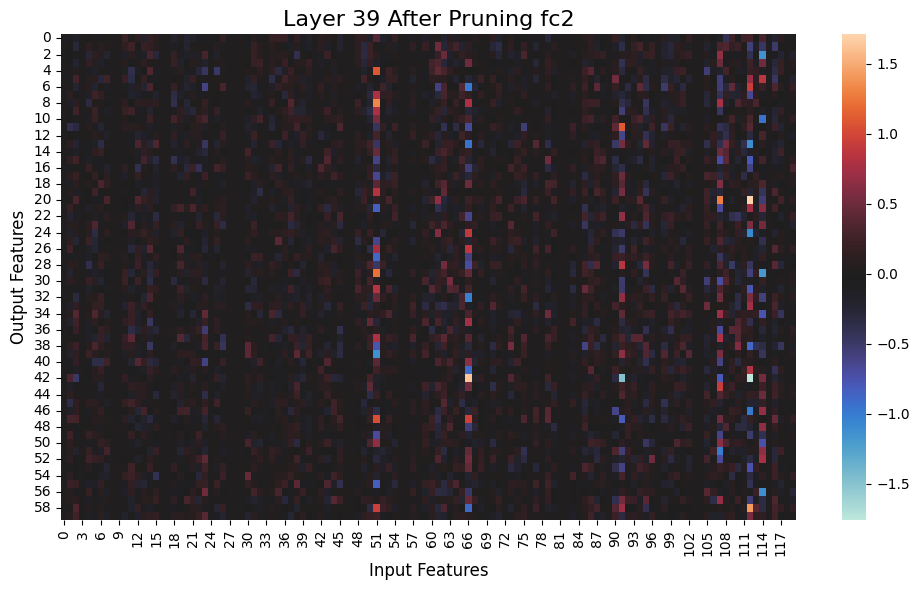

Overall sparsity: 0.3750
model sparsity: 0.1424
sparse model size: 31.4892
------------------------------
pruning: 40 neurons


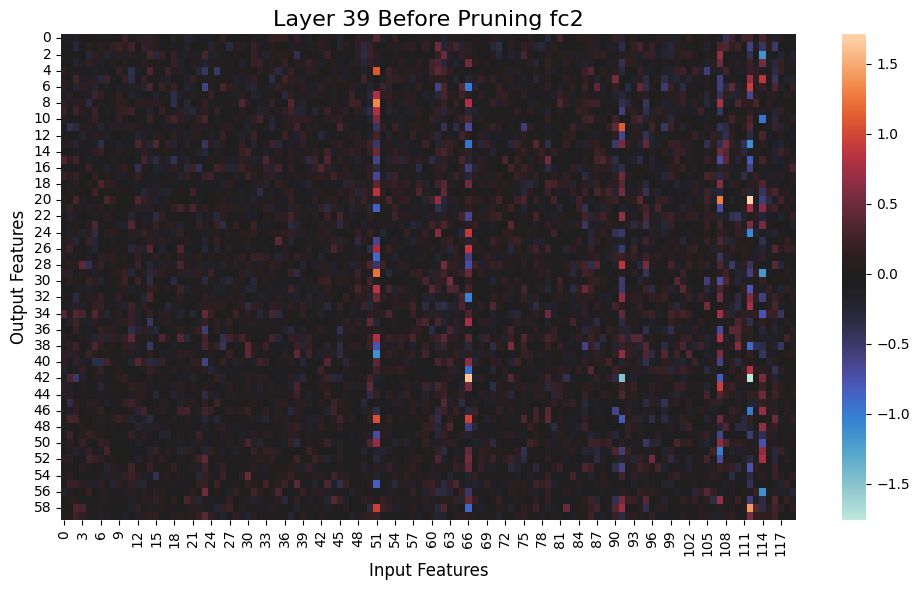

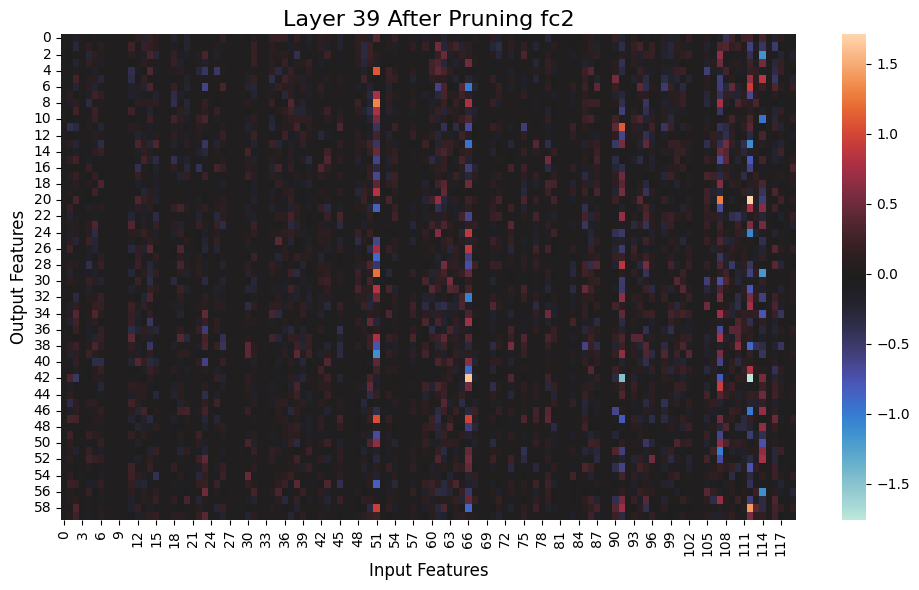

Overall sparsity: 0.5000
model sparsity: 0.1899
sparse model size: 30.6260
------------------------------
pruning: 50 neurons


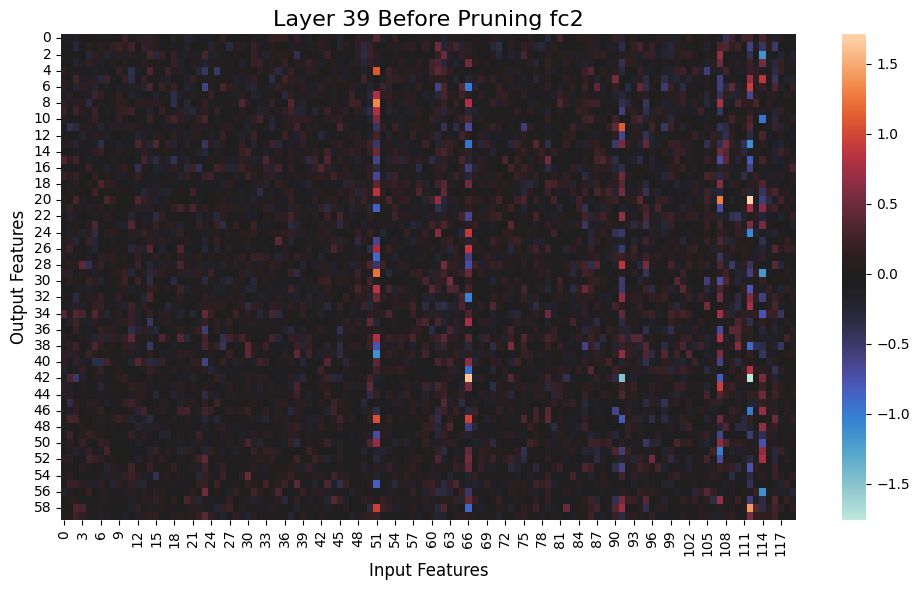

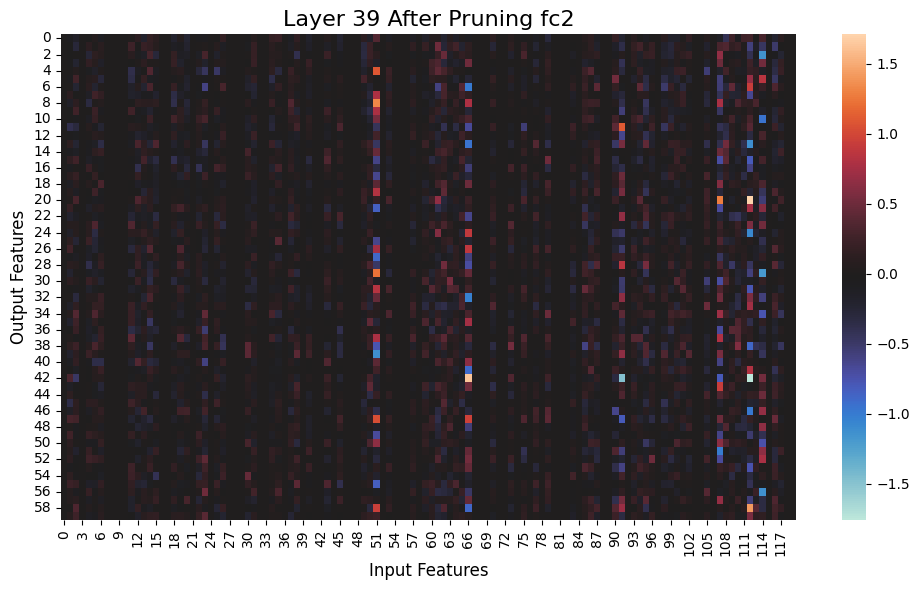

Overall sparsity: 0.6250
model sparsity: 0.2373
sparse model size: 29.7612
------------------------------
pruning: 60 neurons


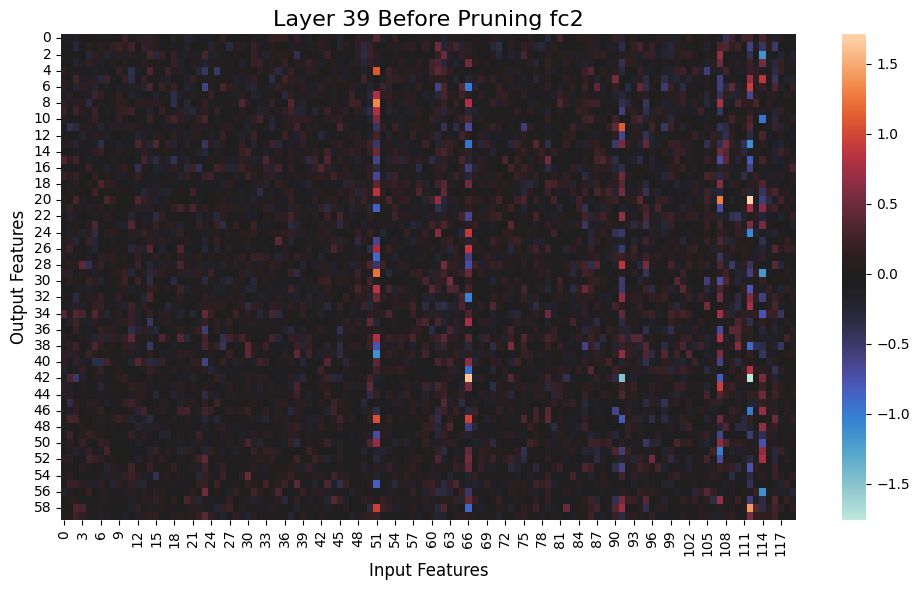

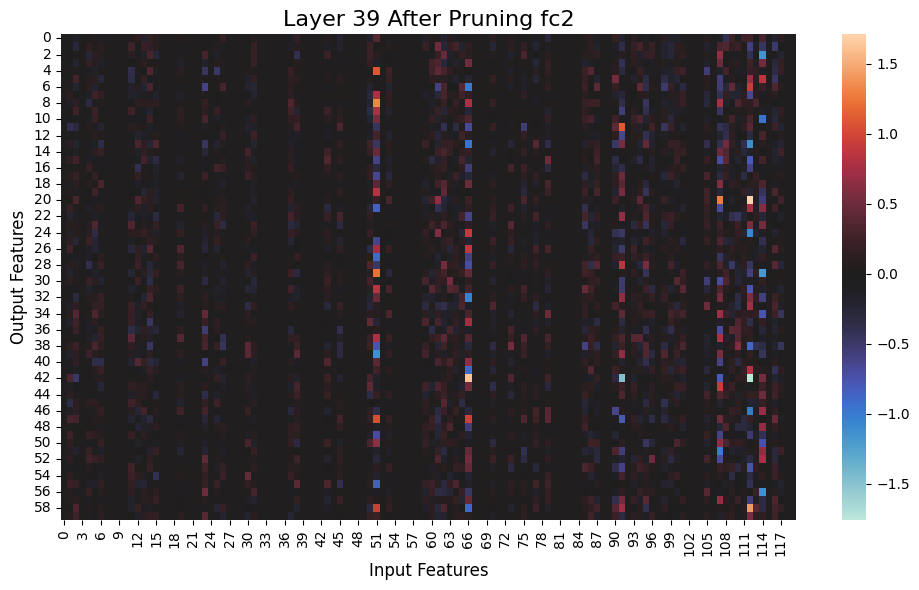

Overall sparsity: 0.7500
model sparsity: 0.2848
sparse model size: 28.8979
------------------------------


In [ ]:
importlib.reload(pu)
# Each Mlp block has 2 linear layers:
# fc1: Linear(in_features=60, out_features=120, bias=True)
# fc2: Linear(in_features=120, out_features=60, bias=True)
# each linear layer has weights of shape (out_features, in_features)
# we prune along dim=1 i.e. input features to a neuron
for pn in range(0, 61, 10):
    print(f"pruning: {pn} neurons")
    mod2prune = copy.deepcopy(model)
    pu.prune_linear_nodes(mod2prune, pn, 39)
    print("-"*30)


In [ ]:
pruning_data_structured_linear_nodes = {
    "Neurons Pruned" : [0, 10, 20, 30, 40, 50, 60],
    "Sparsity (Neurons)" : [0.0, 0.1250, 0.25, 0.3750, 0.5, 0.625, 0.75],
    "Sparsity (Model)" : [0.0, 0.0475, 0.0949, 0.1424, 0.1899, 0.2373, 0.2848],
    "Accuracy" : [],
    "Latency (s)" : [],
    "Disk Size (MB)" : [34.07, 33.22, 32.35, 31.49, 30.63, 29.76, 28.90],
}